In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model

In [2]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

## Load dataset

In [3]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=32, shuffle=False, num_workers=8)
test_loader_single = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

train_set = Dataset(x_train, y_train)
train_loader = data.DataLoader(dataset=train_set, batch_size=32, shuffle=False, num_workers=8)
train_loader_single = data.DataLoader(dataset=train_set, batch_size=1, shuffle=False, num_workers=1)

## Define submodular function candidate

In [4]:
def submodular_candidate_f(
  patched: torch.Tensor,
  patched_with_element: torch.Tensor,
  # no_patch: torch.Tensor,
  y,
):
  """
  F_S(i) = F(S + {i}) - F(S)
  
  [tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>),
  tensor([[1.5141]], grad_fn=<UnsqueezeBackward0>),
  tensor([[0.4459]], grad_fn=<UnsqueezeBackward0>),
  tensor([[0.5643]], grad_fn=<UnsqueezeBackward0>)]
  """
  output = np.array(list(map(lambda x: x.detach().numpy(), model(patched))))
  output_with_element = np.array(list(map(lambda x: x.detach().numpy(), model(patched_with_element))))
  # output_og = np.array(list(map(lambda x: x.detach().numpy(), model(no_patch))))
  
  y = y.detach().numpy().squeeze()
  
  FS = ((y - output.squeeze()) ** 2)
  FSi = ((y - output_with_element.squeeze()) ** 2)
  
  return FSi - FS

## Apply white patches


In [5]:
def apply_path(
    mutable_img_or_batch: torch.Tensor,
    x: int,
    y: int,
    size: int,
) -> torch.Tensor:
    cv2.circle(mutable_img_or_batch, (x, y), size, [255], -1)

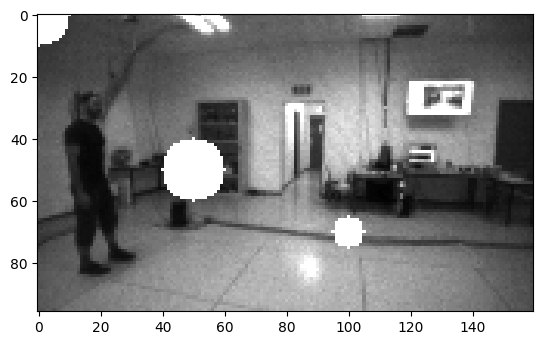

In [6]:
for x, y in test_loader_single:
    apply_path(
        mutable_img_or_batch=x[0][0].numpy(),
        x=50,
        y=50,
        size=10
    )
    
    apply_path(
        mutable_img_or_batch=x[0][0].numpy(),
        x=0,
        y=0,
        size=10
    )
    
    apply_path(
        mutable_img_or_batch=x[0][0].numpy(),
        x=100,
        y=70,
        size=5
    )
    
    plt.imshow(x[0][0], cmap='gray')
    break

## Check if function is submodular


All possible patches positions:  1728


  0%|          | 0/4028 [00:00<?, ?it/s]

ground truth: tensor([[2.7144, 1.6457, 0.4579, 0.9933]])


<timed exec>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
<timed exec>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


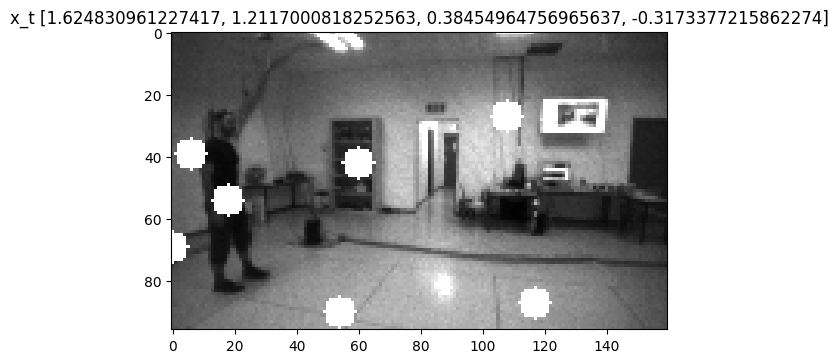

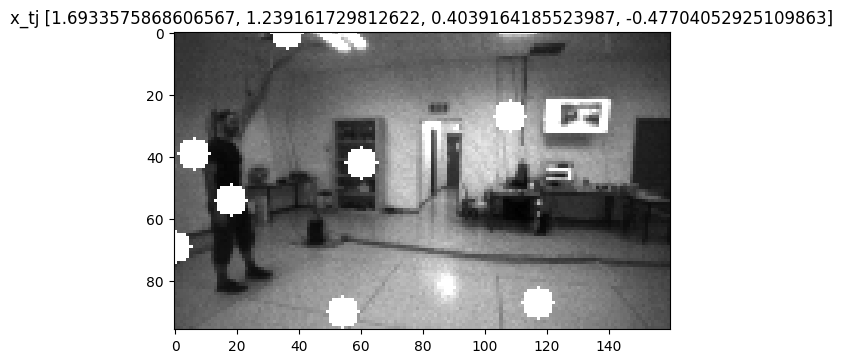

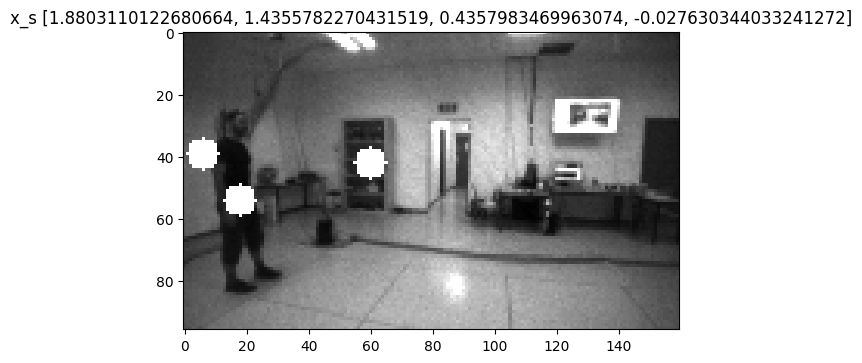

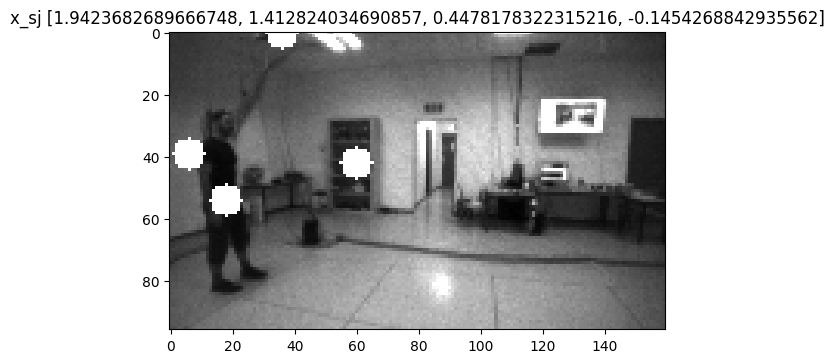

  0%|          | 0/4028 [00:01<?, ?it/s]

F_s:  [-0.09967011  0.01007913 -0.00038633  0.2543962 ]
F_t:  [-0.14463162 -0.02308145 -0.00246524  0.44412458]
CPU times: user 2.18 s, sys: 252 ms, total: 2.43 s
Wall time: 1 s


In [7]:
%%time
PATCH_SIZE = 5
N, M = 160, 96

all_patches_positions = set([(x, y) for x in range(0, N, 3) for y in range(0, M, 3)])
print("All possible patches positions: ", len(all_patches_positions))

result = np.zeros(4)
for x, y in tqdm(test_loader_single, total=len(test_loader_single)):
    for _ in range(10):
        T_size = random.randrange(5, 8)
        S_size = random.randrange(1, T_size)

        T = random.sample(all_patches_positions, T_size)
        S = random.sample(T, S_size)
        j = random.sample(all_patches_positions - set(T), 1)

        x_s, x_sj, x_t, x_tj = x.clone(), x.clone(), x.clone(), x.clone()
    
        for px, py in T:
            apply_path(
                mutable_img_or_batch=x_t[0][0].numpy(),
                x=px,
                y=py,
                size=PATCH_SIZE
            )
        
        for px, py in S:
            apply_path(
                mutable_img_or_batch=x_s[0][0].numpy(),
                x=px,
                y=py,
                size=PATCH_SIZE
            )
        
        for px, py in T + j:
            apply_path(
                mutable_img_or_batch=x_tj[0][0].numpy(),
                x=px,
                y=py,
                size=PATCH_SIZE
            )
        
        for px, py in S + j:
            apply_path(
                mutable_img_or_batch=x_sj[0][0].numpy(),
                x=px,
                y=py,
                size=PATCH_SIZE
            )
        
        F_s = submodular_candidate_f(y=y, patched=x_s, patched_with_element=x_sj).squeeze()
        F_t = submodular_candidate_f(y=y, patched=x_t, patched_with_element=x_tj).squeeze()
        result += (F_s > F_t)

        def _foo(pred):
            tmp = list(map(lambda x: float(x.detach().numpy().squeeze()), pred))
            return tmp
        
        
        print(f"ground truth: {y}")
        plt.imshow(x_t[0][0], cmap='gray')
        plt.title(f"x_t {_foo(model(x_t))}")
        plt.show()
        plt.imshow(x_tj[0][0], cmap='gray')
        plt.title(f"x_tj {_foo(model(x_tj))}")
        plt.show()
        plt.imshow(x_s[0][0], cmap='gray')
        plt.title(f"x_s {_foo(model(x_s))}")
        plt.show()
        plt.imshow(x_sj[0][0], cmap='gray')
        plt.title(f"x_sj {_foo(model(x_sj))}")
        plt.show()
        
        print(f"F_s: ", F_s)
        print("F_t: ", F_t)
        break
    break

In [8]:
result / (4028 * 10)

array([0.00002483, 0.00002483, 0.00002483, 0.        ])

## TODO show some examples of submodular 

## Results

1. Running once per each image

```
    T_size = random.randrange(2, 100)
    S_size = random.randrange(1, T_size)
    PATH_SIZE = 5
```

`array([0.77060576, 0.75645482, 0.62264151, 0.63356504])`

2. Running 20x per image

```
    T_size = random.randrange(2, 100)
    S_size = random.randrange(1, T_size)
    PATH_SIZE = 5
```

`array([0.77718471, 0.75759682, 0.61091112, 0.63941162])`

3. Running 2x per image

```
    T_size = random.randrange(2, 100)
    S_size = random.randrange(1, T_size)
    PATH_SIZE = 10
```

`array([0.61246276, 0.67961768, 0.60985601, 0.60116683])`

4. Running 2x per image

```
    T_size = random.randrange(2, 50)
    S_size = random.randrange(1, T_size)
    PATH_SIZE = 5
```

`array([0.75235849, 0.74702085, 0.64051639, 0.65863952])`